# Project 2: Inverse kinematics and resolved rate control

In this project, we implemented an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

The [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

I have set the numpy random number generator seed to 10 using `np.random.seed(10)`. I did it so that the results are reproducible.

I have used to following helper functions to calculate various quantities including the jacobian, and inverse kinematics of the 

In [6]:
"""
Function Definitions & global variable declarations
"""
import numpy as np
from scipy.linalg import logm, expm


# convert 3x1 vector to skew
def vec_to_skew(w):
    return np.r_[np.c_[0, -w[2], w[1]], np.c_[w[2], 0, -w[0]], np.c_[-w[1], w[0], 0]]


# calculate screw from w and p
def calc_screw(w, p):

    S = np.zeros((6, 7))
    for i in range(7):
        S[0:3, i] = w[:, i]
        S[3:, i] = -vec_to_skew(w[:, i]) @ p[:, i]

    return S


# convert 6x1 twist vector to skew
def twist_to_skew(V):
    return np.r_[np.c_[vec_to_skew(V[:3]), V[3:]], np.c_[np.zeros((1, 3)), 0]]


# compute T from R, p
def trans_from_rot_pos(R, p):
    return np.r_[np.c_[R, p], np.c_[np.zeros((1, 3)), 1]]


# compute T from V
def exp_twist_bracket(V):
    return expm(twist_to_skew(V))


# find the inverse of T
def invT(T):
    return np.linalg.inv(T)


# get adjoint of T matrix
def getAdjoint(T):
    return np.r_[
        np.c_[T[0:3, 0:3], np.zeros((3, 3))],
        np.c_[vec_to_skew(T[0:3, 3]) @ T[0:3, 0:3], T[0:3, 0:3]],
    ]


# Define screws, zero config pose, w and p
W = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 1, 0, -1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1]])
P = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, -0.0607, 0],
        [0.1575, 0.36, 0.5645, 0.78, 0.9645, 1.18, 1.261],
    ]
)
S = calc_screw(W, P)
M = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1.301], [0, 0, 0, 1]])

# copute forward kinematics given a list of joint angles
def forward_kinematics(theta):
    """
    Computes the forward kinematics for the robot.
    """
    global S
    global M

    T = np.array(M)
    for i in range(theta.shape[0]):
        T = exp_twist_bracket(S[:, -i - 1] * theta[-i - 1][0]) @ T
    return T


# Compute jacobian in frame aligned ith space and origin at body
def get_jacobian(theta):
    global S
    Js = np.array(S).copy()
    T = np.eye(4)
    for i in range(1, theta.shape[0]):
        T = T @ exp_twist_bracket(S[:, i - 1] * theta[i - 1][0])
        Js[:, i] = getAdjoint(T) @ np.array(S)[:, i]

    # get position using pose matrix
    pos = forward_kinematics(theta)[0:3, 3]

    # compute jacobian in frame aligned with space and origin at body
    Tfs = np.r_[np.c_[np.eye(3), pos], np.c_[np.zeros((1, 3)), 1]]
    Jf = getAdjoint(invT(Tfs)) @ Js

    return Jf

# Compute jacobian in frame aligned ith space and origin at body
def get_jacobian(theta):
    global S
    Js = np.array(S).copy()
    T = np.eye(4)
    for i in range(1, theta.shape[0]):
        T = T @ exp_twist_bracket(S[:, i - 1] * theta[i - 1][0])
        Js[:, i] = getAdjoint(T) @ np.array(S)[:, i]

    # get position using pose matrix
    pos = forward_kinematics(theta)[0:3, 3]

    # compute jacobian in frame aligned with space and origin at body
    Tfs = np.r_[np.c_[np.eye(3), pos], np.c_[np.zeros((1, 3)), 1]]
    Jf = getAdjoint(invT(Tfs)) @ Js

    return Jf


## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [7]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.)

In [8]:
def compute_IK_position(
    desired_position,
    error=0.001,
    step=0.1,
    initial_theta=np.zeros([7, 1]),
    max_iterations=75,
):
    solution_found = False
    curr_theta = initial_theta
    best_theta = None

    num_iterations = tqdm(range(max_iterations))
    for iteration in num_iterations:
        # set options for progressbar
        time.sleep(0.1)
        num_iterations.set_description(f"Processing iteration {iteration + 1}")

        # compute current position of end effector
        curr_position = forward_kinematics(curr_theta)[0:3, 3].reshape((3, 1))

        # error at current iteration
        curr_error = desired_position - curr_position
        delta_theta = np.linalg.pinv(get_jacobian(curr_theta)[3:]) @ curr_error

        # see whether error is appropriate
        if np.linalg.norm(curr_error) < error:
            best_theta = curr_theta
            solution_found = True
            break

        # increment theta
        curr_theta = curr_theta + step * delta_theta

    return best_theta, solution_found


In [9]:
thetas = []
bools = []
for i in range(desired_endeff.shape[1]):
    print(f"Computing inverse kinematics for configuration {i+1}")
    g, b = compute_IK_position(desired_endeff[:, i].reshape(3, 1))
    thetas.append(g)
    bools.append(b)

print(f"Joint angles: {thetas}")
print(f"Whether solution exists: {bools}")


Computing inverse kinematics for configuration 1


NameError: name 'tqdm' is not defined

In [ ]:
def compute_IK_position_nullspace(
    desired_position,
    theta_bar=np.array([[1], [1], [-1], [-1], [1], [1], [1]]),
    error=0.001,
    step=0.1,
    initial_theta=np.zeros([7, 1]),
    max_iterations=75,
):
    solution_found = False
    curr_theta = initial_theta
    best_theta = None
    num_iterations = tqdm(range(max_iterations))
    for iteration in num_iterations:
        # set options for progressbar
        time.sleep(0.1)
        num_iterations.set_description(f"Processing iteration {iteration + 1}")

        # compute current position of end effector
        curr_position = forward_kinematics(curr_theta)[0:3, 3].reshape((3, 1))

        # error at current iteration
        curr_error = desired_position - curr_position
        delta_theta = np.linalg.pinv(get_jacobian(curr_theta)[3:]) @ curr_error + (
            np.eye(7)
            - np.linalg.pinv(get_jacobian(curr_theta)[3:])
            @ get_jacobian(curr_theta)[3:]
        ) @ (theta_bar - curr_theta)

        # see whether error is appropriate
        if np.linalg.norm(curr_error) < error:
            best_theta = curr_theta
            solution_found = True
            break

        # increment theta
        curr_theta = curr_theta + step * delta_theta

    return best_theta, solution_found


In [ ]:
thetas = []
bools = []
for i in range(desired_endeff.shape[1]):
    print(f"Computing inverse kinematics for configuration {i+1}")
    g, b = compute_IK_position_nullspace(desired_endeff[:, i].reshape(3, 1))
    thetas.append(g)
    bools.append(b)

print(f"Joint angles: {thetas}")
print(f"Whether solution exists: {bools}")


## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [ ]:
T = 10.0
end_effector_goal1 = np.array([[0.7], [0.2], [0.7]])
end_effector_goal2 = np.array([[0.3], [0.5], [0.9]])

theta1, success1 = compute_IK_position_nullspace(end_effector_goal1)
theta2, success2 = compute_IK_position_nullspace(end_effector_goal2)

In [ ]:
def get_point_to_point_motion(desired_initial_position, desired_final_position, t, T):
    """
    Returns desired position and velocity as a function of time t
    """
    desired_position = desired_initial_position + (
        10 * (t / T) ** 3 - 15 * (t / T) ** 4 + 6 * (t / T) ** 5
    ) * (desired_final_position - desired_initial_position)
    desired_velocity = (
        30 * (t ** 2 / T ** 3) - 60 * (t ** 3 / T ** 4) + 30 * (t ** 4 / T ** 5)
    ) * (desired_final_position - desired_initial_position)
    return desired_position, desired_velocity


In [ ]:
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])

    if t < 5:
        desired_joint_positions, desired_joint_velocities = get_point_to_point_motion(
            np.zeros([7, 1]), theta1, t, T / 2
        )
    else:
        desired_joint_positions, desired_joint_velocities = get_point_to_point_motion(
            theta1, theta2, t - 5, T / 2
        )
    
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
    
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

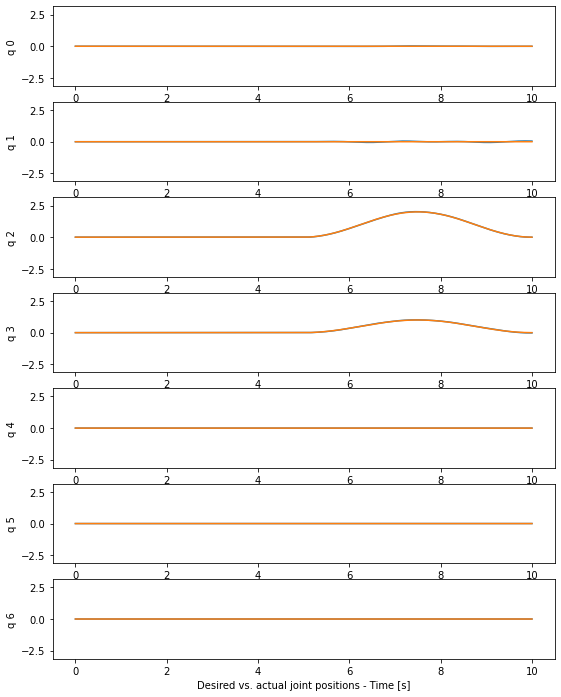

In [ ]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

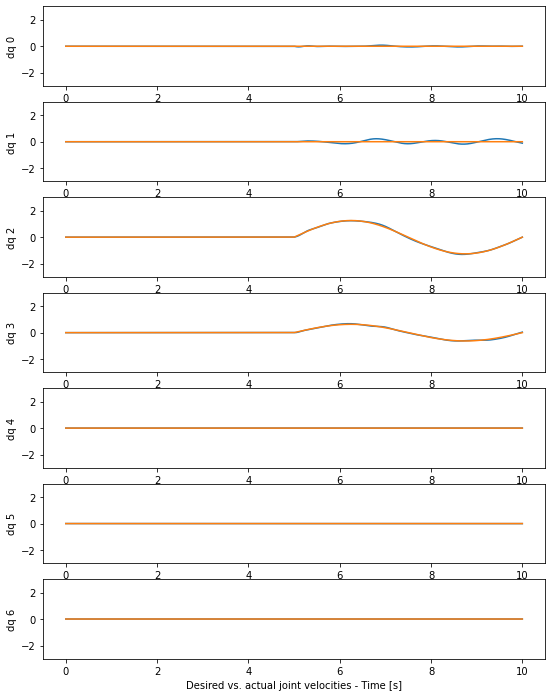

In [ ]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [9]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

## Question 4: Impedance control and gravity compensation
As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ``robot_visualizer.rnea(q,dq,ddq)`` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q,\dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?

In [10]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
    ##TODO - implement gravity compensation and impedance control
    
    desired_joint_torques = -np.diag(D) @ joint_velocities
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)